## 전처리

In [34]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dbfread import DBF
from haversine import haversine
from tqdm.notebook import tqdm
%matplotlib inline
import platform
import pickle
import re
platform.system()
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'
!pip install dbfread
!pip install haversine

## SKT API 서울시 구별 성별 연령별 일자별 시간별 유동인구

In [35]:
def pklopen(route):
    with open('{}'.format(route), 'rb') as f:
        df = pickle.load(f)
    return df
time = pklopen('./time.pkl')

In [36]:
#구의 종류
time['gu'].unique()

array(['중구', '구로구', '서대문구', '성동구', '송파구', '용산구', '성북구', '영등포구', '동작구',
       '중랑구', '노원구', '양천구', '강남구', '강서구', '관악구', '강동구', '은평구', '마포구',
       '도봉구', '종로구', '서초구', '동대문구', '강북구', '광진구', '금천구'], dtype=object)

In [37]:
#나이 종류
time['age'].unique()

array([70, 20, 40, 50, 30, 60], dtype=int64)

In [38]:
time_sorted = time.sort_values(by=['age', 'datetime', 'time'], axis=0)
time_sorted

,datetime,date,time,gu,age,ppl,sex
4109,2020-01-01,20200101,0,금천구,20,14220,여성
6151,2020-01-01,20200101,0,중랑구,20,25030,남성
10330,2020-01-01,20200101,0,강남구,20,43680,남성
24665,2020-01-01,20200101,0,도봉구,20,19950,남성
30655,2020-01-01,20200101,0,양천구,20,29620,남성
...,...,...,...,...,...,...,...
195866,2020-07-31,20200731,23,성동구,70,13530,여성
199770,2020-07-31,20200731,23,금천구,70,10740,여성
221273,2020-07-31,20200731,23,노원구,70,16500,남성
221274,2020-07-31,20200731,23,중랑구,70,13350,남성


In [39]:
time_sorted.set_index(['datetime', 'time'])

date   gu  age    ppl sex
datetime   time                               
2020-01-01 0     20200101  금천구   20  14220  여성
           0     20200101  중랑구   20  25030  남성
           0     20200101  강남구   20  43680  남성
           0     20200101  도봉구   20  19950  남성
           0     20200101  양천구   20  29620  남성
...                   ...  ...  ...    ...  ..
2020-07-31 23    20200731  성동구   70  13530  여성
           23    20200731  금천구   70  10740  여성
           23    20200731  노원구   70  16500  남성
           23    20200731  중랑구   70  13350  남성
           23    20200731  마포구   70  17770  여성

[1524000 rows x 5 columns]

## 구별, 일별, 시간별 같은 연령끼리 유동인구

In [40]:
timeday = time_sorted.groupby(['datetime', 'date', 'gu', 'age', 'time']).sum()
timeday = timeday.reset_index()
#2월 1일 기준 20대 한번 보자(1월은 명절)
k = timeday[timeday['datetime']=='2020-02-01'].head(24)
k

,datetime,date,gu,age,time,ppl
111600,2020-02-01,20200201,강남구,20,0,85360
111601,2020-02-01,20200201,강남구,20,1,83380
111602,2020-02-01,20200201,강남구,20,2,81670
111603,2020-02-01,20200201,강남구,20,3,80830
111604,2020-02-01,20200201,강남구,20,4,80150
111605,2020-02-01,20200201,강남구,20,5,79960
111606,2020-02-01,20200201,강남구,20,6,80830
111607,2020-02-01,20200201,강남구,20,7,83890
111608,2020-02-01,20200201,강남구,20,8,92110
111609,2020-02-01,20200201,강남구,20,9,104370


Text(0.5, 1.0, '2월1일 강남구 20대의 시간별 유동인구')

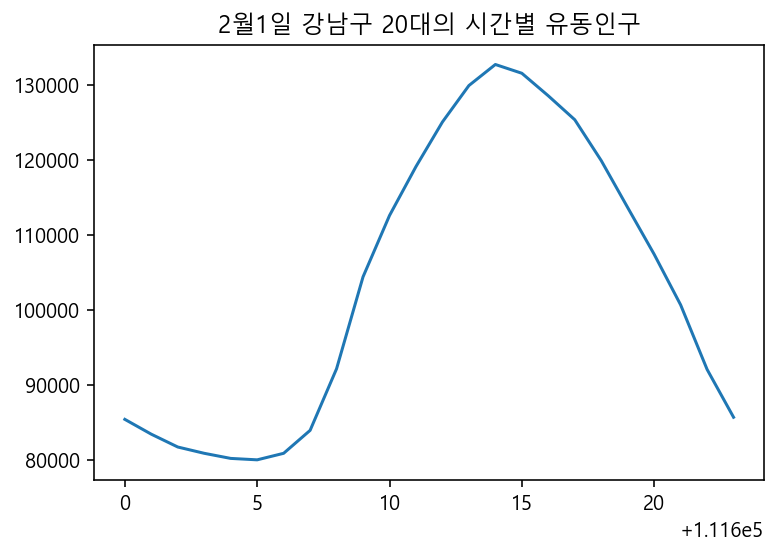

In [41]:
plt.plot(k['ppl'])
plt.title('2월1일 강남구 20대의 시간별 유동인구')

## 이제 구별 일별 민감도(연령별은 나중에 추가하기)

In [42]:
timegu = time_sorted.groupby(['datetime', 'date','gu']).sum()
timegu = timegu.reset_index()
del timegu['age']
del timegu['time']
timegu.set_index(['datetime'], inplace=True)
timegu['week'] =0
timegu.reset_index(inplace=True)
timegu['week']=timegu['datetime'].dt.week
timegu

,datetime,date,gu,ppl,week
0,2020-01-01,20200101,강남구,11001340,1
1,2020-01-01,20200101,강동구,8296230,1
2,2020-01-01,20200101,강북구,6160610,1
3,2020-01-01,20200101,강서구,10998410,1
4,2020-01-01,20200101,관악구,10003990,1
...,...,...,...,...,...
5295,2020-07-31,20200731,용산구,5271470,31
5296,2020-07-31,20200731,은평구,7699220,31
5297,2020-07-31,20200731,종로구,5752320,31
5298,2020-07-31,20200731,중구,6066250,31


In [43]:
fpop_gu = timegu.groupby(['gu', 'week'])['ppl'].sum().divide(7000000).round(2).reset_index()
fpop_gu

,gu,week,ppl
0,강남구,1,9.65
1,강남구,2,15.02
2,강남구,3,15.08
3,강남구,4,12.89
4,강남구,5,13.97
...,...,...,...
770,중랑구,27,6.96
771,중랑구,28,6.95
772,중랑구,29,6.95
773,중랑구,30,6.94


In [44]:
#민감도 랭킹 시각화 함수
def plot_region_fpop_sensitivity(df, x_axis, rot_x=True, show_xlabel=True):
  plt.figure(figsize=(18, 6))

  pal = sns.color_palette("Oranges_r", df.shape[0])
  rank = df['코로나19_유동인구_민감도'].argsort().argsort()
  sns.barplot(x=x_axis, y='코로나19_유동인구_민감도', data=df, palette=np.array(pal[::-1])[rank])
  plt.axhline(0.15, color='red', alpha=0.5, label='서울시 전체 코로나19 유동인구 민감도')
  for idx, score in enumerate(df.코로나19_유동인구_민감도):
    plt.text(idx-0.4, score+0.01, score, size=13, weight='bold')

  plt.title(f'서울시 {x_axis}별 코로나19 유동인구 민감도', size=25)
  plt.legend(fontsize=15)
  plt.ylabel('코로나19 유동인구 민감도', size=15)
  if rot_x:
    plt.xticks(rotation=45, size=15, ha='right')
  if show_xlabel:
    plt.xlabel(x_axis, size=15)
  else:
    plt.xlabel(None)

  plt.show()

In [45]:
## 주차별 유동인구 데이터 시각화 함수
def plot_region_fpop(df, gu_nm=None, dong_code=None):
  if gu_nm is not None:
    region = gu_nm
    tmp_df = df[df.gu==gu_nm].copy()\
                .groupby('week')['ppl'].sum().divide(7000000).round(2).reset_index()
  elif dong_code is not None:
    region = f'{timegu.loc[timegu.adstrd_code == dong_code, "gu"].iloc[0]} ' +\
             f'{timegu.loc[timegu.adstrd_code == dong_code, "adstrd_nm"].iloc[0]}'
    tmp_df = df[df.adstrd_code==dong_code].copy()\
                .groupby('week')['ppl'].sum().divide(7000).round(2).reset_index()
  else:
    region = '서울시'
    tmp_df = timegu.groupby('week')['ppl'].sum().divide(7000000).round(2).reset_index()
  
  pre_fpop = tmp_df.loc[tmp_df.week.isin(range(2,4)), 'ppl'].sum()/2
  post_fpop = tmp_df.loc[tmp_df.week.isin(range(9,13)), 'ppl'].sum()/4
  fpop_sensitivity = round((pre_fpop - post_fpop)/(pre_fpop), 3)

  tmp_df['week'] = tmp_df['week'].apply(lambda x : f'weekofyear_{x}')
  

  plt.figure(figsize=(18, 6))
  pal = sns.color_palette("Greens_d", tmp_df.shape[0])
  rank = tmp_df['ppl'].argsort().argsort()
  sns.barplot(x='week', y='ppl', data=tmp_df, palette=np.array(pal[::-1])[rank])
  plt.plot([1.5, 9.5], [pre_fpop, post_fpop], '-or', label=f'{region} 코로나19 유동인구 민감도 : {fpop_sensitivity}')
  plt.text(1, pre_fpop*1.05, f'2-3주차 평균\n({pre_fpop:.3f})', size=15)
  plt.text(9, post_fpop*1.05, f'9-12주차 평균\n({post_fpop:.3f})', size=15)
  plt.axvspan(1.5-1, 1.5+1, color='red', alpha=0.2)
  plt.axvspan(9.5-2, 9.5+2, color='red', alpha=0.2)

  plt.title(f'{region} 주차별 일평균 유동인구', size=20)
  plt.xticks(rotation=45, size=15, ha='right')
  plt.xlabel('주차별', size=15)
  ylabel = '유동인구수(천명)' if dong_code is not None else '유동인구수(백만명)'
  plt.ylabel(ylabel, size=15)
  plt.legend(fontsize=15, loc='upper right')
  plt.ylim(0, tmp_df.ppl.max()*1.2)
  plt.show()


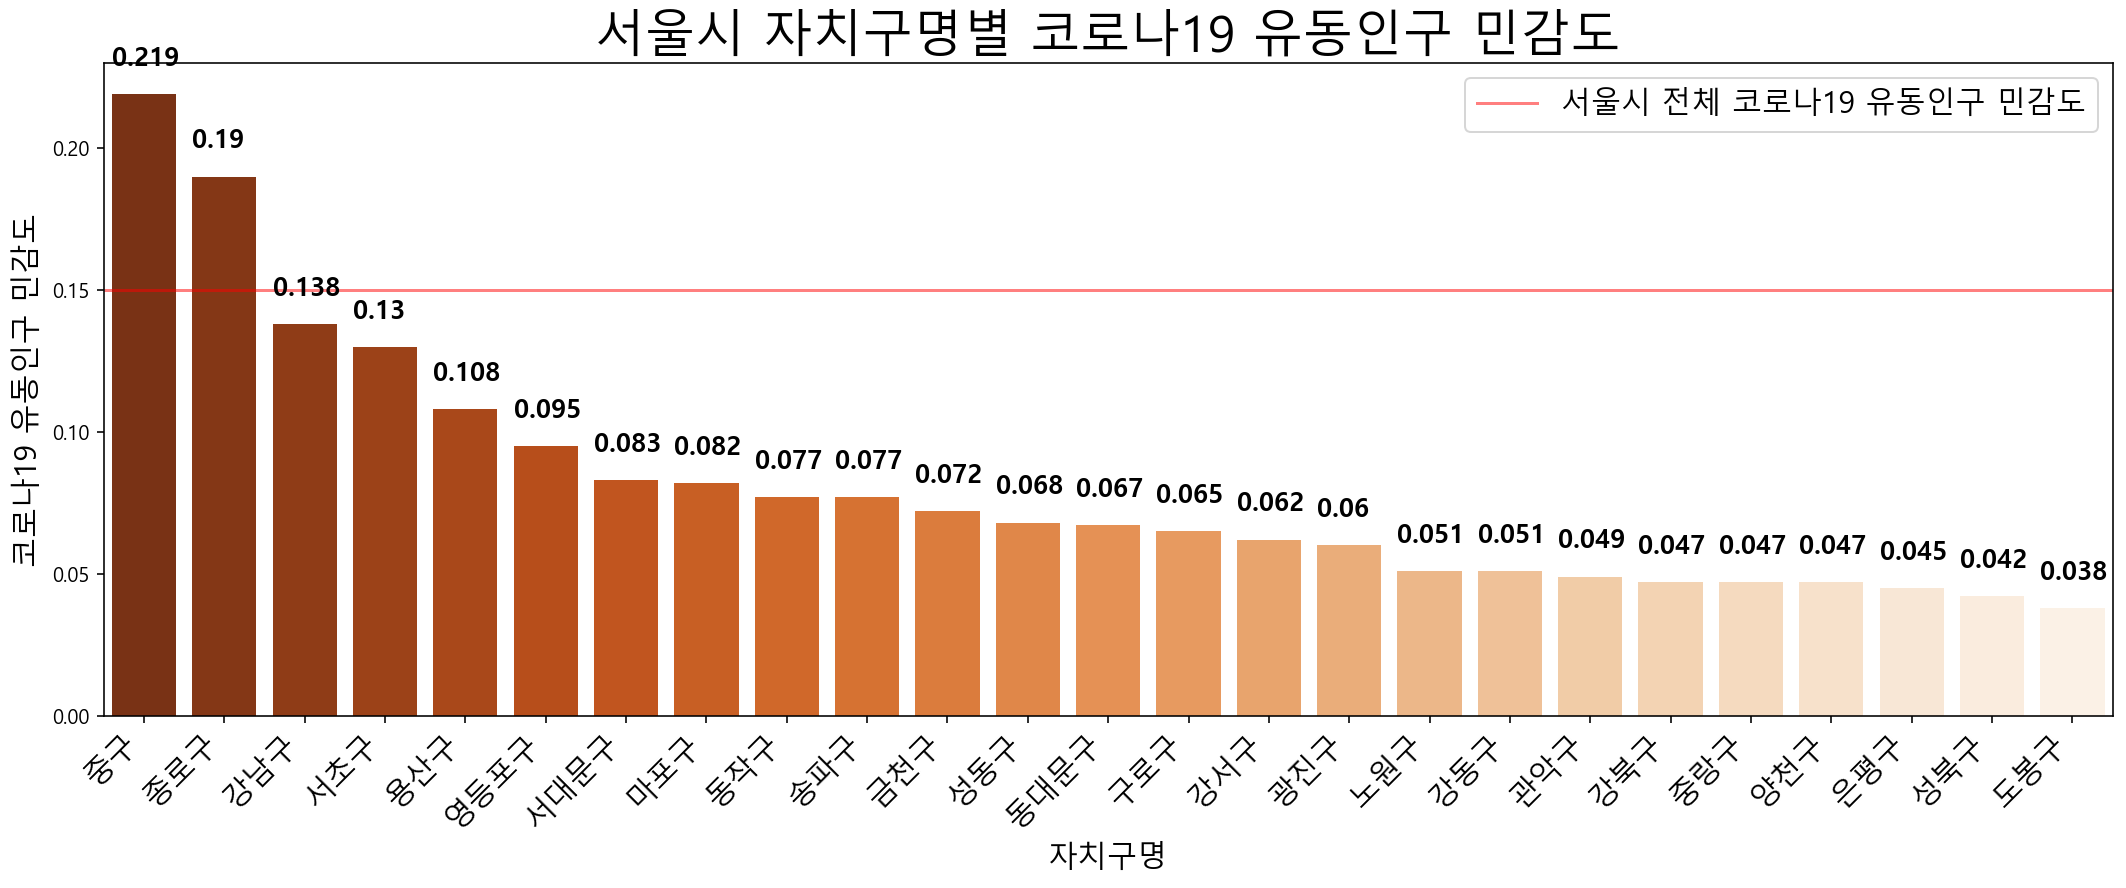

In [50]:
tmp_list = []
for gu in fpop_gu.gu.unique():
  tmp_df = fpop_gu[fpop_gu.gu==gu]
  tmp_pre = tmp_df.loc[fpop_gu.week.isin(range(2,4)), 'ppl'].mean()
  tmp_post = tmp_df.loc[fpop_gu.week.isin(range(9, 12)), 'ppl'].mean()
  tmp_sensitivity = round((tmp_pre - tmp_post)/tmp_pre, 3)
  tmp_list.append(tmp_sensitivity)

fpop_sensitivity_gu = pd.DataFrame({'자치구명':fpop_gu.gu.unique(), '코로나19_유동인구_민감도':tmp_list})\
                        .sort_values('코로나19_유동인구_민감도', ascending=False).reset_index(drop=True)

# 자치구별 코로나19 유동인구 민감도 막대 그래프
plot_region_fpop_sensitivity(df=fpop_sensitivity_gu, x_axis='자치구명')



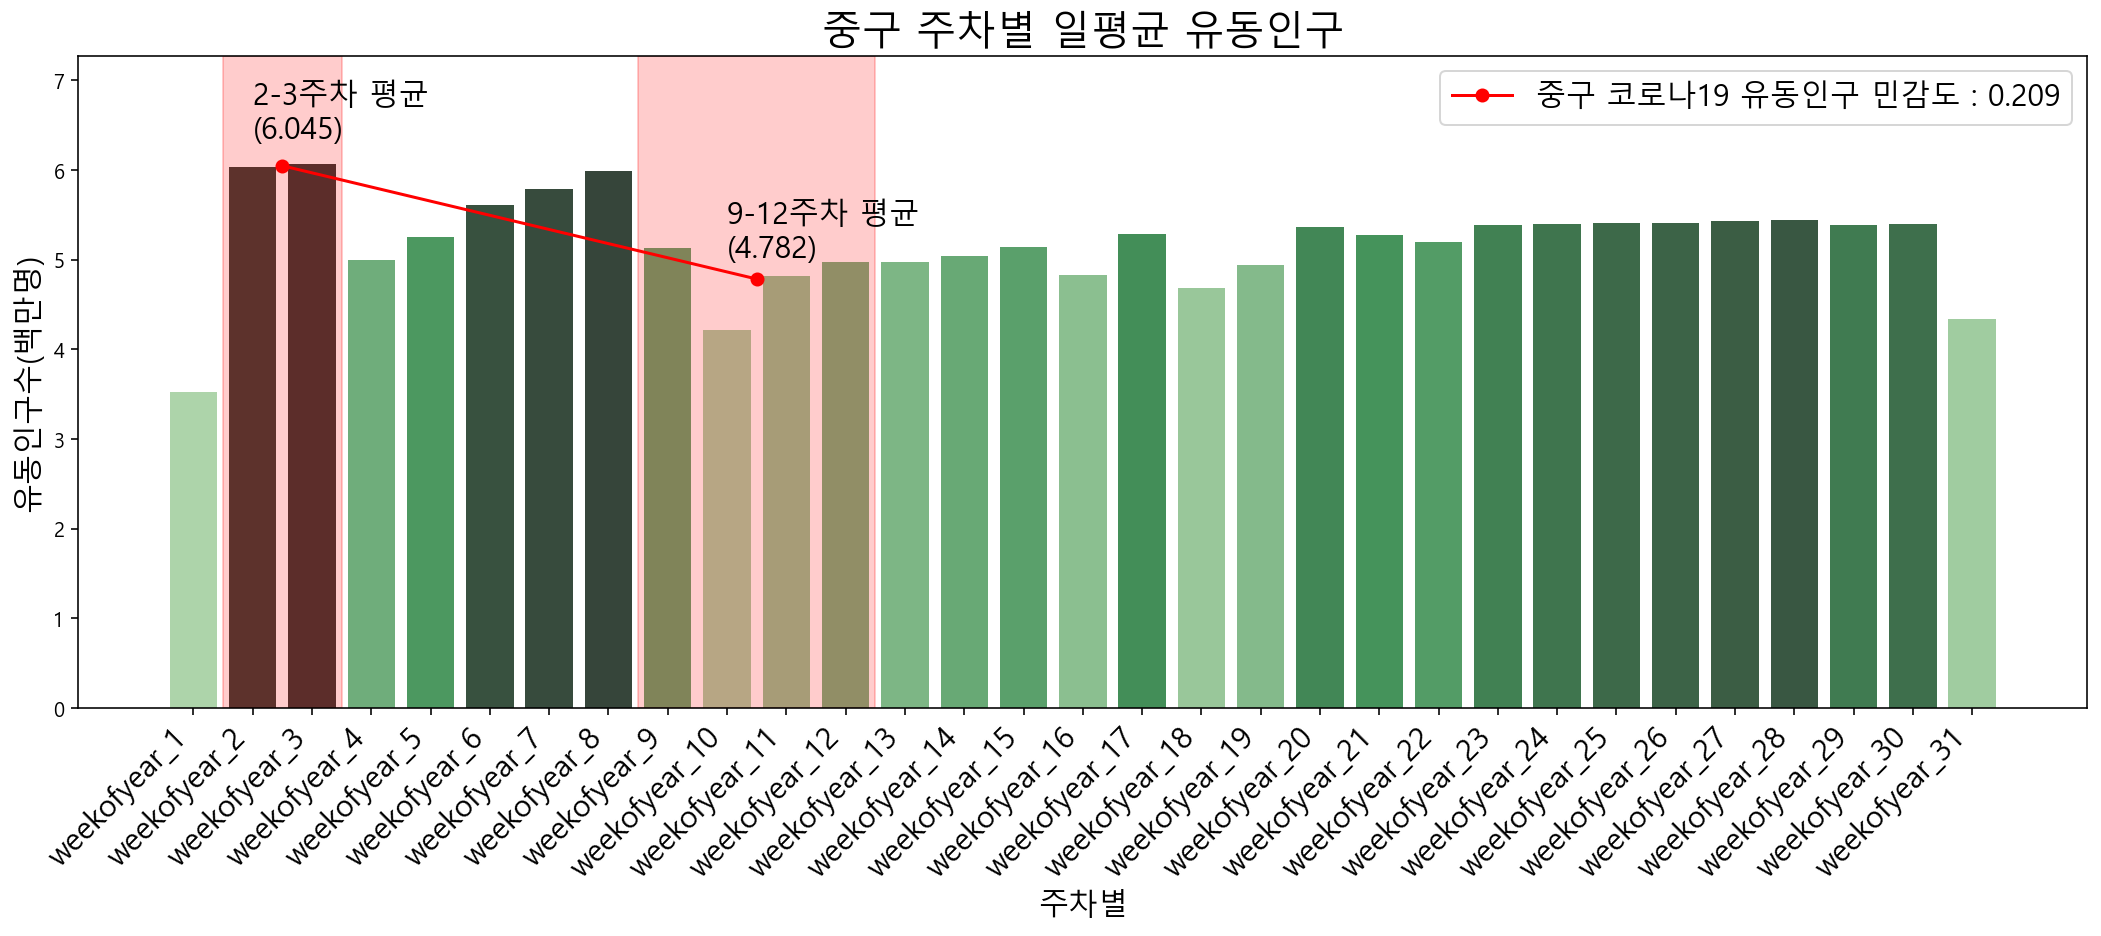

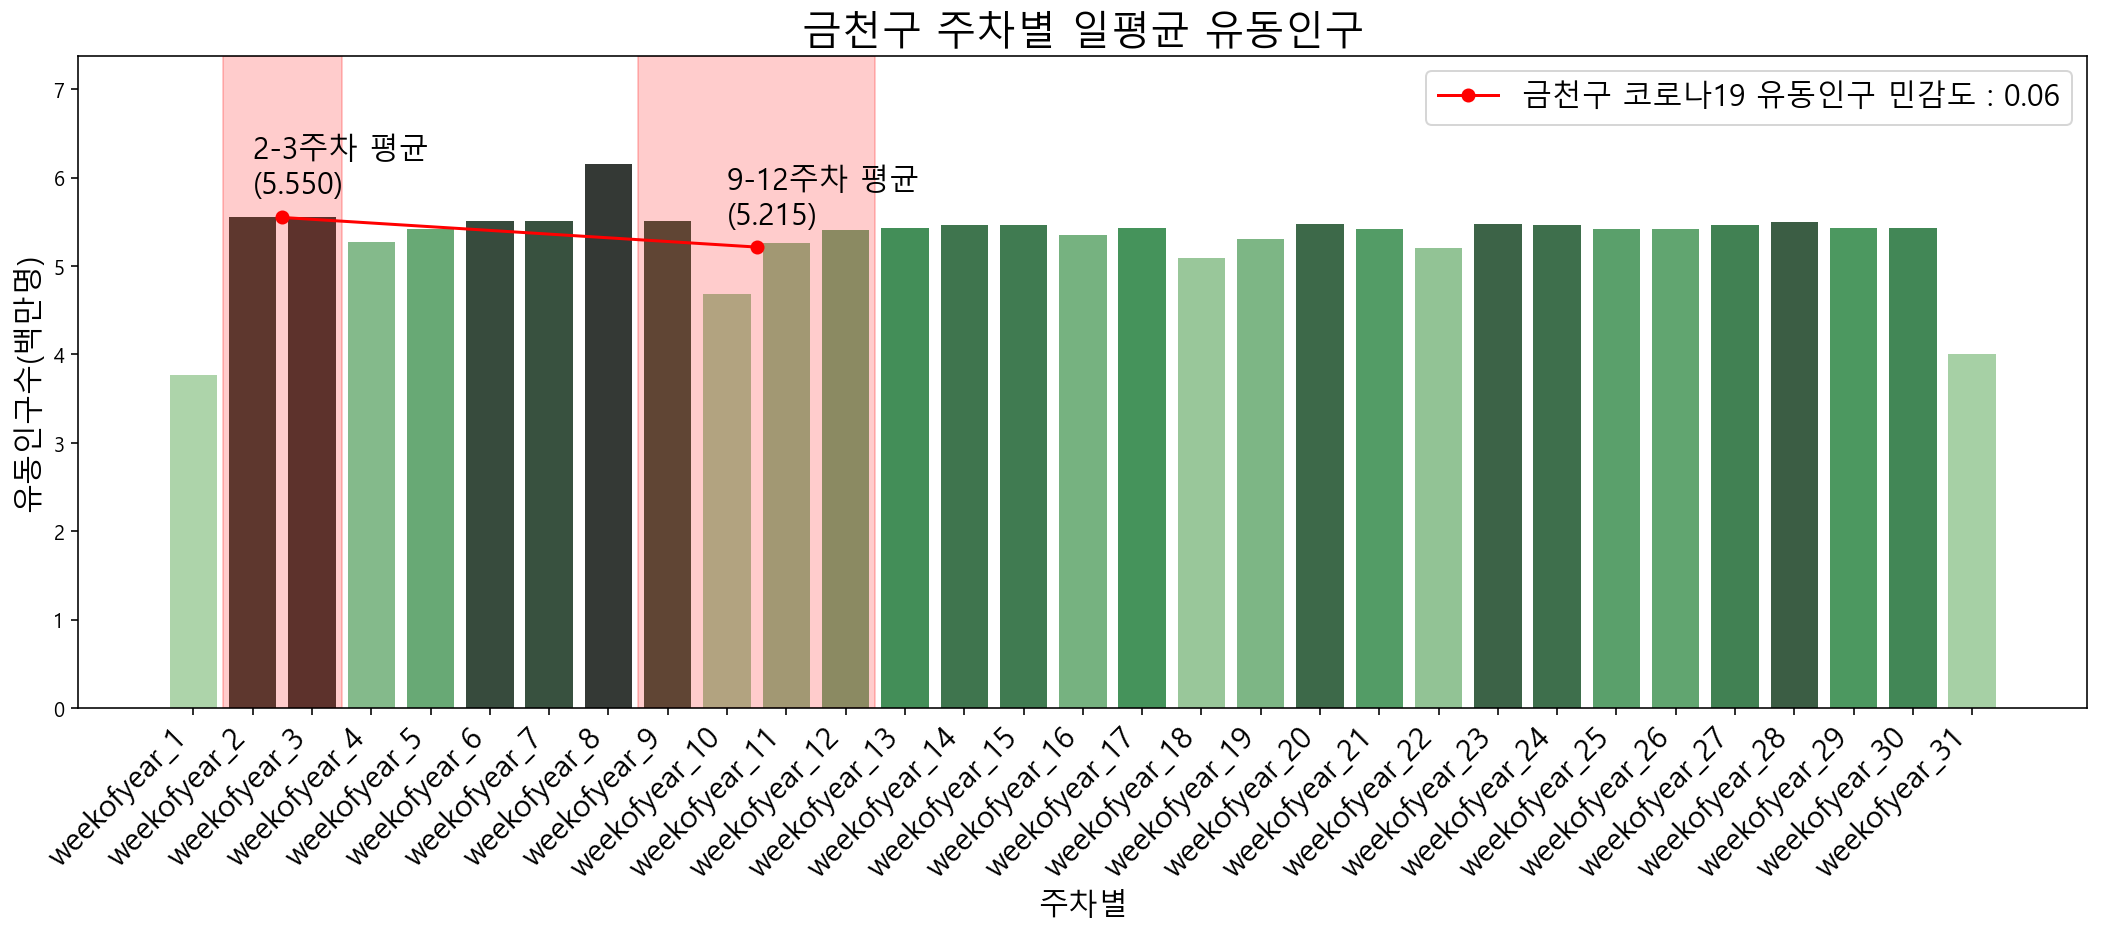

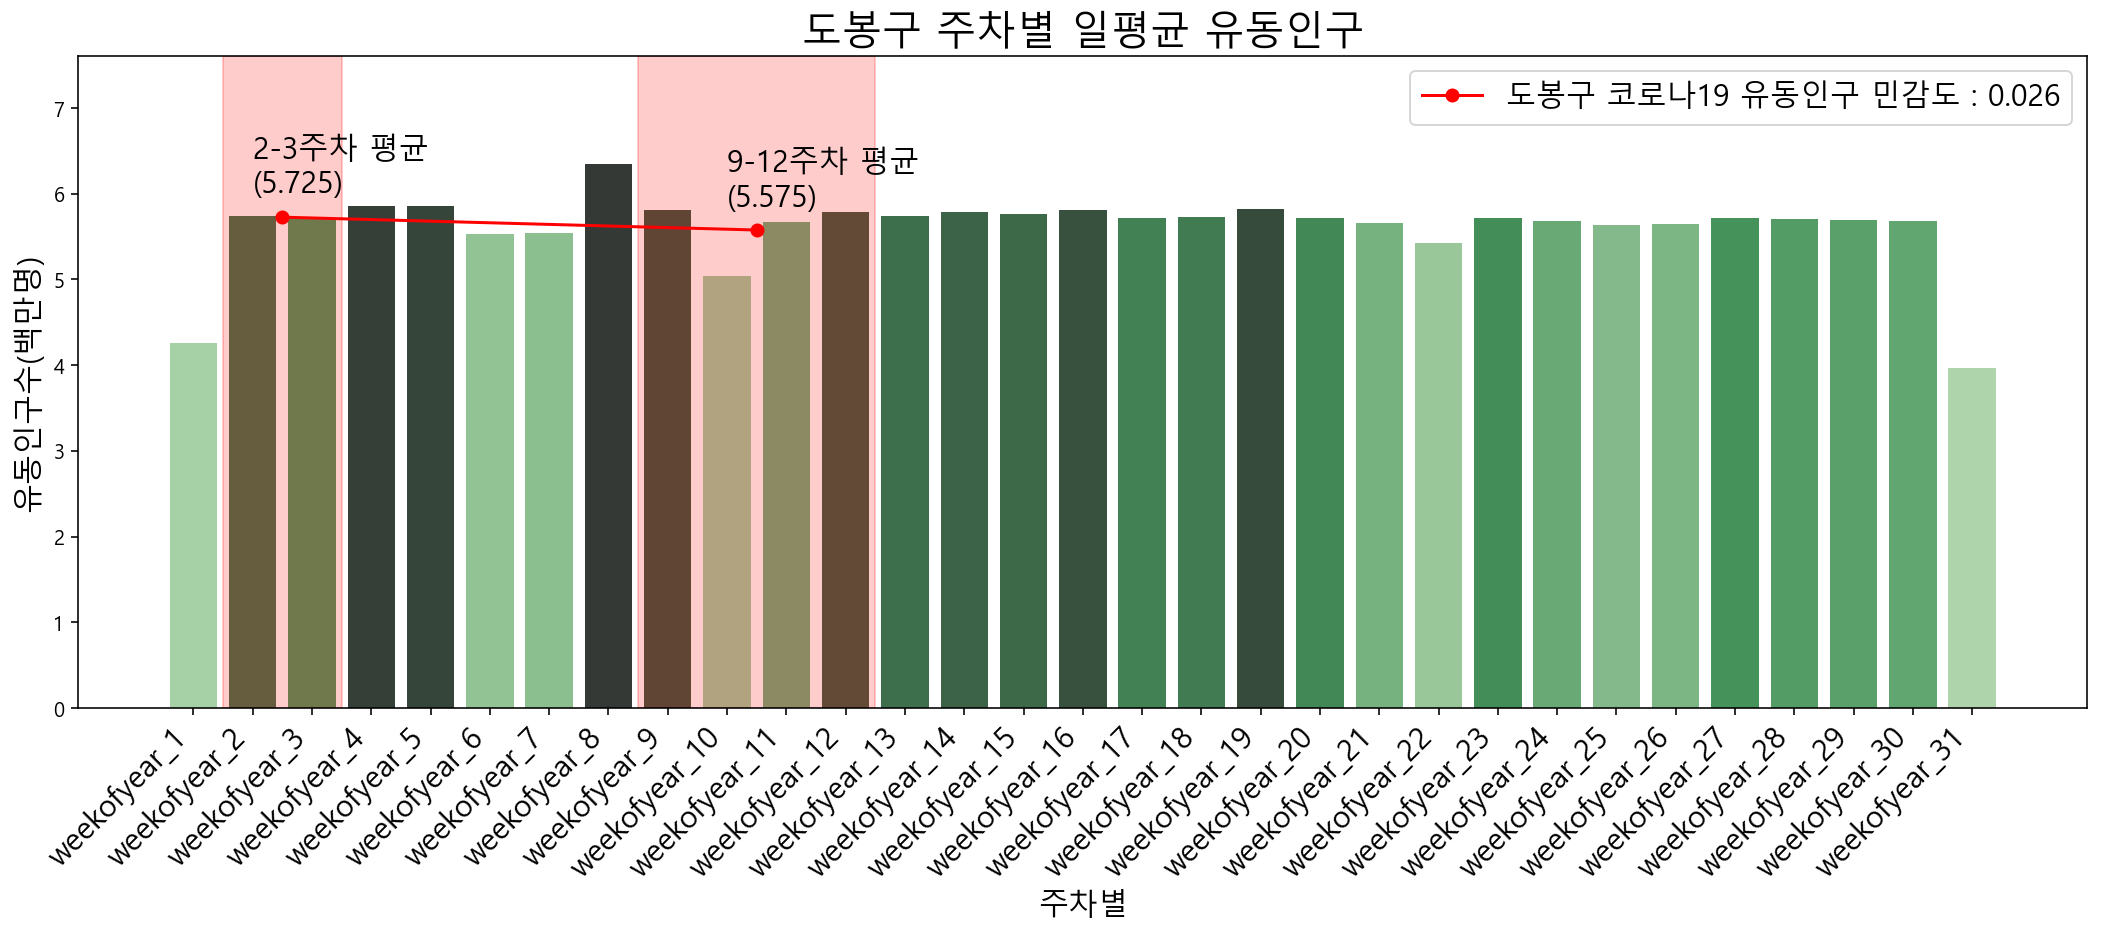

In [54]:
plot_region_fpop(df=timegu, gu_nm='중구')
plot_region_fpop(df=timegu, gu_nm='금천구')
plot_region_fpop(df=timegu, gu_nm='도봉구')